In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
import tensorflow as tf

In [3]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 2: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 3: # 6:2:2
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)

  return train_data, test_data, val_data

In [4]:

# load the dataset
df = pd.read_csv('/content/drive/MyDrive/IS403.N22/Project/dataset/TSLA_Stock.csv',usecols=['Date', 'Price'], parse_dates=['Date'], index_col='Date')
df.head()

,Price
Date,
2017-12-01,20.44
2017-12-04,20.35
2017-12-05,20.25
2017-12-06,20.88
2017-12-07,20.75


In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_data, test_data, val_data = split_data(scaled_data, 1)

Train:  974
Test:  278
Val:  140


In [6]:

n_steps = 10
n_features = 1

# Tạo hàm input sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Tạo input sequences cho training, validation, và testing
X_train, y_train = create_sequences(train_data, n_steps)
X_val, y_val = create_sequences(val_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)


In [7]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# RNN

model = Sequential()
model.add(SimpleRNN(50, input_shape=(n_steps, n_features)))
model.add(Dense(1))


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')#, metrics=[MeanAbsolutePercentageError()])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
31/31 [==============================] - 3s 12ms/step - loss: 0.0121 - val_loss: 0.0077
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 8.3971e-04 - val_loss: 0.0109
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 6.2132e-04 - val_loss: 0.0078
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 5.4667e-04 - val_loss: 0.0054
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 5.5574e-04 - val_loss: 0.0047
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 4.6886e-04 - val_loss: 0.0053
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 4.4192e-04 - val_loss: 0.0036
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 4.2033e-04 - val_loss: 0.0042
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 3.2180e-04 - val_loss: 0.0031
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 3.

In [11]:
# evaluate trên tập test
loss_test = model.evaluate(X_test, y_test, verbose=0)
print("loss_test: ", loss_test)

# evaluate trên tập val
loss_val = model.evaluate(X_val, y_val, verbose=0)
print("loss_val: ", loss_val)

loss_test:  0.0010322617599740624
loss_val:  0.0004252067010384053


In [12]:
def mae_rmse_mape(true, predict):
  mae = mean_absolute_error(true, predict)
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return mae, rmse, mape

In [13]:
y_pred_test = model.predict(X_test, verbose=0)
y_pred_val = model.predict(X_val, verbose=0)

In [14]:
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

y_test = scaler.inverse_transform(y_test)
y_val = scaler.inverse_transform(y_val)
y_train = scaler.inverse_transform(y_train)

In [15]:
mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, y_pred_test)
mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, y_pred_val)

print('MAE of Test: ', mae_test)
print('RMSE of Test: ', rmse_test)
print('MAPE of Test: ', mape_test)
print('------------------------')
print('MAE of Validation: ', mae_val)
print('RMSE of Validation: ', rmse_val)
print('MAPE of Validation: ', mape_val)

MAE of Test:  9.808690627368529
RMSE of Test:  12.788558439968027
MAPE of Test:  0.03507269089779616
------------------------
MAE of Validation:  6.601209582989033
RMSE of Validation:  8.207801799611225
MAPE of Validation:  0.03974981792610327


In [16]:
mae_rmse_mape(y_test, y_pred_test)

(9.808690627368529, 12.788558439968027, 0.03507269089779616)

In [17]:
mae_rmse_mape(y_val, y_pred_val)

(6.601209582989033, 8.207801799611225, 0.03974981792610327)

In [18]:
number_days = 30

last_sequence = X_val[-1:]

predicted_values = []

for _ in range(number_days):
    next_value = model.predict(last_sequence)
    predicted_values.append(next_value[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [next_value], axis=1)

1/1 [==============================] - 0s 22ms/step


In [19]:
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
#predicted_values = np.array(predicted_values).reshape(-1, 1)

In [20]:
# # Create an array of dates for the time steps
# dates = df.index

# # Plot the training data
# plt.figure(figsize=(12, 6))
# plt.plot(dates[:len(y_train)], y_train, label='Train')

# # Plot the validation data
# test_offset = len(y_train)
# plt.plot(dates[test_offset:test_offset + len(y_test)], y_test, label='Test')
# plt.plot(dates[test_offset:test_offset + len(y_pred_test)], y_pred_test, label='Test Predictions')

# # Plot the testing data
# val_offset = test_offset + len(y_test)
# plt.plot(dates[val_offset:val_offset + len(y_val)], y_val, label='Validation')
# plt.plot(dates[val_offset:val_offset + len(y_pred_val)], y_pred_val, label='Validation Predictions')

# next30days_offset = pd.date_range(start=dates[-1], periods=31, closed='right')
# plt.plot(next30days_offset, predicted_values, label='30 next days')

# # Rotate x-axis labels for better visibility
# plt.xticks(rotation=45)

# plt.legend()
# plt.show()

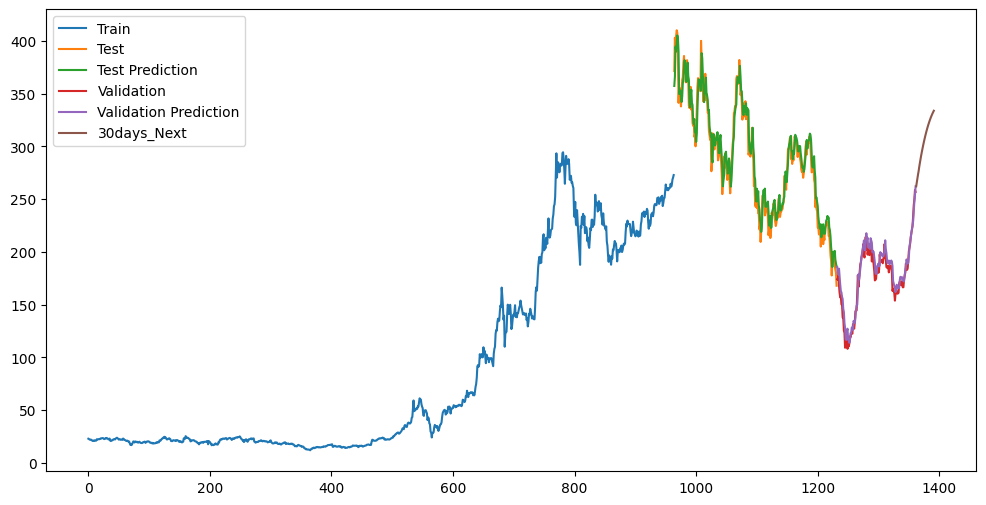

In [23]:
plt.figure(figsize=(12,6))

plt.plot(range(len(y_train)), y_train, label='Train')

plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, label='Test Prediction')

plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, label='Validation')
plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_pred_val, label='Validation Prediction')

plt.plot(range(len(y_train) + len(y_test) + len(y_val), len(y_train) + len(y_test) + len(y_val) + number_days), predicted_values, label='30days_Next')

plt.legend()
plt.show()